Install dependencies

## Load environment and imports

In [2]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from IPython.display import display
from dotenv import load_dotenv

# Load .env for REPLICATE_API_TOKEN
load_dotenv()

# Set token manually if needed:
os.environ["REPLICATE_API_TOKEN"] = "r8_cpYoTjX5oMjtwuJXVrfAF1JvaJMybOm1d0Yl3"

import replicate

client = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])


## CLIP Embedding functions

In [3]:
CLIP_MODEL = "openai/clip"

def embed_image(path):
    with open(path, "rb") as f:
        output = client.run(CLIP_MODEL, input={"image": f})
    return np.array(output["embedding"])


def embed_text(text):
    output = client.run(CLIP_MODEL, input={"text": text})
    return np.array(output["embedding"])


## Load frames

In [4]:
FRAMES_DIR = Path("output_frames")

image_paths = sorted(FRAMES_DIR.glob("*.jpg"))
print(f"Found {len(image_paths)} frames")


Found 155 frames


## Embedd all frames

In [5]:
image_embeddings = {}

print("Embedding frames…")

for path in image_paths:
    emb = embed_image(path)
    image_embeddings[path] = emb

print("Done!")


Embedding frames…
Done!


## Cosine similarity function

In [6]:
from numpy.linalg import norm

def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))


## Text search function

In [7]:
def search_frames_clip(query, top_k=10):
    print(f"Searching for: {query}")

    query_emb = embed_text(query)

    scores = []
    for path, emb in image_embeddings.items():
        score = cosine_similarity(query_emb, emb)
        scores.append((path, score))

    # sort by similarity descending
    scores.sort(key=lambda x: x[1], reverse=True)

    return scores[:top_k]


## Display results with thumbnails

In [8]:
def show_results(results):
    for path, score in results:
        print(f"{path.name} — score: {score:.3f}")
        
        img = Image.open(path)
        img.thumbnail((300, 300))
        display(img)


## Run text query

Searching for: man with a t-shirt of black background and white text
frame_00044.jpg — score: 0.210


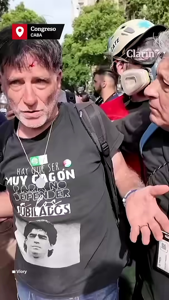

frame_00048.jpg — score: 0.201


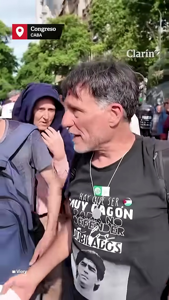

frame_00047.jpg — score: 0.200


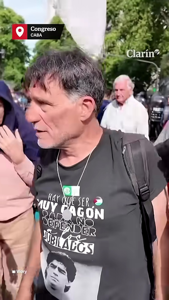

frame_00153.jpg — score: 0.194


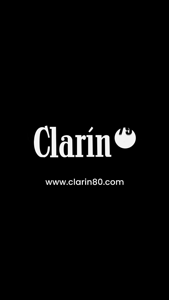

frame_00154.jpg — score: 0.189


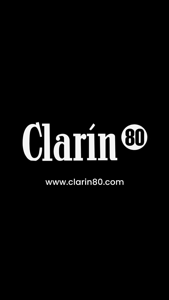

frame_00089.jpg — score: 0.184


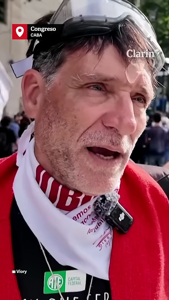

frame_00135.jpg — score: 0.181


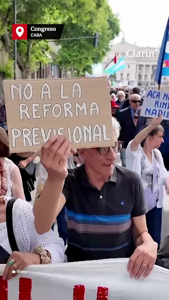

frame_00081.jpg — score: 0.181


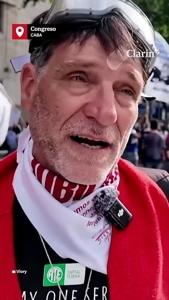

frame_00101.jpg — score: 0.176


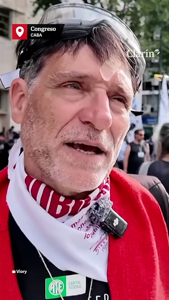

frame_00109.jpg — score: 0.173


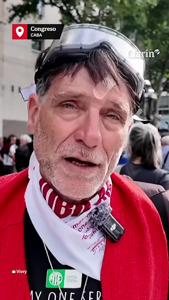

In [9]:
results = search_frames_clip("man with a t-shirt of black background and white text", top_k=10)
show_results(results)

## Image-to-Image search

In [10]:
import numpy as np
from PIL import Image
from IPython.display import display

def cosine_similarity(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))


def search_by_image(query_image_path, top_k=10):
    """
    Uses CLIP embeddings to search for frames visually similar to the query image.
    Works with your existing embed_image() + image_embeddings.
    """
    print(f"Searching similar frames for: {query_image_path}")

    # Get embedding for query image
    query_emb = embed_image(query_image_path)

    scored = []

    # Compare query to all stored frame embeddings
    for path, emb in image_embeddings.items():
        sim = cosine_similarity(query_emb, emb)
        scored.append((path, sim))

    # Sort highest similarity first
    scored.sort(key=lambda x: x[1], reverse=True)

    return scored[:top_k]


def show_image_matches(results):
    """
    Displays thumbnails of matching frames.
    """
    print("\nTop matching frames:\n")

    for path, sim in results:
        print(f"{path.name} — similarity: {sim:.3f}")
        img = Image.open(path)
        img.thumbnail((300, 300))
        display(img)


## Run image-to-image search

In [11]:
query = "input_image_for_search/camera.jpeg"  
results = search_by_image(query, top_k=10)
show_image_matches(results)

Searching similar frames for: input_image_for_search/camera.jpeg


FileNotFoundError: [Errno 2] No such file or directory: 'input_image_for_search/camera.jpeg'